In [ ]:
"""
Code for computing the amount of shared surface area between two neighborhoods
'cells2': Main dataframe output by neighborhoodtemplate with x,y,clusterID, and neighborhood allocation
"""

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
cells2 = pd.read_pickle('main_fcs')

In [2]:
tissue_col = 'spots'
neigh_col = 'neighborhood10'
patient_col = 'patients'
group_col = 'groups'
X = 'X:X'
Y = 'Y:Y'

In [3]:
# calculate neighbors for each spot
for spot in cells2[tissue_col].unique():
    tissue =cells2[cells2[tissue_col]==spot]
    fit =  NearestNeighbors(n_neighbors=1).fit(tissue[[X,Y]].values)
    m = fit.kneighbors()[1]
    
    cells2.loc[tissue.index,'neigh_neigh'] = tissue.iloc[m[:,0],:][neigh_col].values
cells2['neigh_neigh'] = cells2['neigh_neigh'].astype(int)   

In [4]:
#compute for each patient, in each tissue and neighborhood, the number of cells in that neighborhoood
counts = cells2.groupby([group_col,patient_col,tissue_col,neigh_col]).apply(lambda x: len(x)).unstack()

#compute for each patient, in each tissue and neighborhood:  the count of how many of the cells in that neighborhood are next to a cell in the other neighborhood
neighs = cells2.groupby([group_col,patient_col,tissue_col,neigh_col]).apply(lambda x:x['neigh_neigh'].value_counts(sort = False)).unstack()



In [5]:
#specify which neighborhoods you want to calculate
neigh1,neigh2 = 0,4

In [6]:
# Comment out if you wish to average each spot for each patient
N = neighs.sum(level = [group_col,patient_col,neigh_col])
N[tissue_col] = [i[1] for i in N.index]
neighs = N.set_index(tissue_col,append = True).reorder_levels([group_col,patient_col,tissue_col,neigh_col])

In [7]:
# index the values for the neighborhoods of interest
ix = pd.IndexSlice

#take the mean between the number of cells in neigh 1 that touch neigh2 and the number of cells in neigh2 that touch neigh1 
#as not necessarily symmetric
inters = pd.concat([neighs.loc[ix[:,:,:,[neigh1]],[neigh2]],neighs.loc[ix[:,:,:,[neigh2]],[neigh1]]],1).mean(level = [group_col,patient_col,tissue_col]).mean(1)

#calculate the total number of cells in both neighborhoods
wholes = neighs.sum(1).loc[ix[:,:,:,[neigh2,neigh1]]].unstack().sum(1)

combo = pd.concat([inters,wholes],1).dropna((0))
combo['ratio'] = combo[0]/combo[1]
combo = combo.rename(columns = {0:'neighboring',1:'union',2:'ratio'})

combo = combo.reset_index()


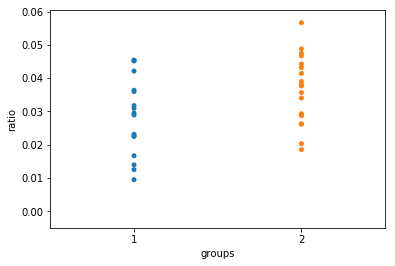

In [8]:
c = combo.reset_index()
sns.stripplot(data = c, x = group_col, y ='ratio')
plt.show()

In [9]:
a = c[c[group_col]==1]['ratio']

In [10]:
b = c[c[group_col]==2]['ratio']

In [11]:
from scipy import stats
stats.ttest_ind(a, b)

Ttest_indResult(statistic=-2.0816172422774324, pvalue=0.045211049299440066)